In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.optimize import fmin_tnc

In [2]:
class model(object):
    def __init__(self, x0, t, v, A, L):
        self.x0 = x0
        self.t = t
        self.v = v
        self.v_g = np.mean(v)
        self.A = A
        self.L = L
        
    def calc_grad(self, Iter):
        A = self.A
        v = self.v
        x = self.rates[Iter,:]
        pre_grad = self.grad[Iter,:,:]
        for i in range(A.shape[0]):
            j = 1-i
            a = pre_grad[i,i] * (1 + A[i,i]*v[i]**2 *(1 - 2*x[i]) - A[i,j]*v[i]*v[j]*x[j])
            b = pre_grad[i,j] * A[i,j]*v[i]*v[j]*(1-x[i])
            c = 2*A[i,j]*v[i]*x[i] - 2*A[i,i]*v[i]*x[i]**2 + A[i,j]*v[j]*x[j] - A[i,j]*v[j]*x[i]*x[j]
            self.grad[Iter, i, i] = a+b+c
            a = pre_grad[i,j] * (1 + A[i,i]*v[i]**2 *(1 - 2*x[i]) - A[i,j]*v[i]*v[j]*x[j])
            b = pre_grad[i,i]*A[i,j]*v[i]*v[j]*(1-x[i])
            c = A[i,j]*v[i]*x[i] - A[i,j]*v[i]*x[i]*x[j]
            self.grad[Iter, i, j] = a+b+c
    
    def calc_grad_g(self, Iter):
        A = self.A
        v = self.v_g
        x = self.rates_g[Iter,:]
        pre_grad = self.grad_g[Iter,:]
        for i in range(A.shape[0]):
            j = 1-i
            a = pre_grad[i] * (1 + v**2*A[i,i] - v**2*A[i,i]*2*x[i] - v**2*A[i,j]*x[j])
            b = pre_grad[j] * (v**2*A[i,j] - v**2*A[i,j]*x[i])
            c = 2*v*A[i,i]*x[i] - 2*v*A[i,i]*x[i]**2 + 2*v*A[i,j]*x[j] - 2*v*A[i,j]*x[i]*x[j]
            self.grad_g[Iter, i] = a+b+c 
        
    def iterate(self, Iter):
        self.rates[Iter,:] = self.x0
        self.grad[Iter,:,:] = 0
        for i in range(1,self.t+1):
            self.rates[Iter,:] = self.rates[Iter,:] + self.v*(1-self.rates[Iter,:])*(np.sum(self.A*self.v*self.rates[Iter,:], axis=1))
            self.calc_grad(Iter)
        self.cost[Iter,:] = self.rates[Iter,:]*self.L + 1/self.v - 1
        self.f_grad[Iter, :] = np.diag(self.grad[Iter,:,:])*self.L - 1/(self.v**2)
    
    def iterate_g(self, Iter):
        self.rates_g[Iter,:] = self.x0
        self.grad_g[Iter,:] = 0
        for i in range(1,self.t+1):
            self.rates_g[Iter,:] = self.rates_g[Iter,:] + self.v_g*(1-self.rates_g[Iter,:])*(np.sum(self.A*self.v_g*self.rates_g[Iter,:], axis=1))
            self.calc_grad_g(Iter)
        self.cost_g[Iter,:] = self.rates_g[Iter,:]*self.L + 1/self.v_g - 1
        self.f_grad_g[Iter, :] = self.grad_g[Iter,:]*self.L - 1/(self.v_g**2)
    
    def train(self, lr, Iter, gov = False):
        self.rates = np.zeros((Iter, x0.shape[0]))
        self.grad = np.zeros((Iter, A.shape[0], A.shape[1]))
        self.f_grad = np.zeros((Iter, A.shape[0]))
        self.cost = np.zeros((Iter, A.shape[0]))
        if gov:
            self.rates_g = np.zeros((Iter, x0.shape[0]))
            self.grad_g = np.zeros((Iter, A.shape[0]))
            self.f_grad_g = np.zeros((Iter, A.shape[0]))
            self.cost_g = np.zeros((Iter, A.shape[0]))
            
        for i in tqdm.tqdm(range(Iter)):
            self.iterate(i)
            self.v = self.v - lr*(self.f_grad[i,:])
            self.v[self.v==0] = 1/np.exp(10)
            if gov:
                self.iterate_g(i)
                self.v_g = self.v_g - lr*(self.f_grad_g[i,0])
                self.v_g = self.v_g - lr*(self.f_grad_g[i,1])
    

In [3]:
x0 = np.array([0.0001,0.1])
t = 150
v = np.array([0.3,0.4])
A = np.array([[0.1,0.2],[0.3,0.1]])
beta = 0.1
A = A*beta
L = np.array([0.8, 0.6])
#temp = contagion_rate(x0, t, v, A)

In [4]:
model = model(x0,t,v,A,L)
itr = 25000

In [5]:
model.train(0.0001,itr, True)
base_v = model.v.copy()
base_cost = model.cost[itr-1].copy()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [09:00<00:00, 46.24it/s]


[0.90390862 0.79493999]


array([0.60229624, 0.67236794])

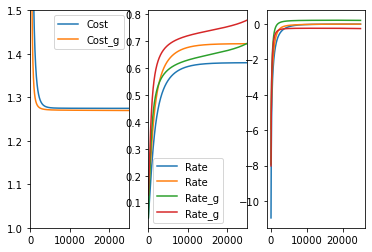

In [22]:
fig, axs = plt.subplots(1,3)
axs[0].plot(range(itr), np.sum(model.cost, axis=1), label='Cost')
axs[0].plot(range(itr), np.sum(model.cost_g, axis=1), label='Cost_g')
axs[1].plot(range(itr), model.rates, label='Rate')
axs[1].plot(range(itr), model.rates_g, label='Rate_g')
axs[2].plot(range(itr), model.f_grad, label='grad')
axs[2].plot(range(itr), model.f_grad_g, label='grad_G')
axs[0].set_ylim([1, 1.5])
for i in range(2):
    axs[i].set_xlim([0, itr])
    axs[i].legend()
print(model.v)
model.cost[itr-1]

In [19]:
np.sum(model.cost, axis=1)

array([3.94820447, 3.93268418, 3.91736383, ..., 1.27466419, 1.27466419,
       1.27466419])

In [27]:
model.rates[245000:]

array([[0.61995533, 0.69065368],
       [0.61995534, 0.69065369],
       [0.61995534, 0.6906537 ],
       ...,
       [0.61998688, 0.69068525],
       [0.61998688, 0.69068526],
       [0.61998689, 0.69068526]])

In [3]:
def calc_grad(A, v, x, grad):
    pre_grad = grad
    for i in range(A.shape[0]):
        j = 1-i
        a = pre_grad[i,i] * (1 + A[i,i]*v[i]**2 *(1 - 2*x[i]) - A[i,j]*v[i]*v[j]*x[j])
        b = pre_grad[i,j] * A[i,j]*v[i]*v[j]*(1-x[i])
        c = 2*A[i,j]*v[i]*x[i] - 2*A[i,i]*v[i]*x[i]**2 + A[i,j]*v[j]*x[j] - A[i,j]*v[j]*x[i]*x[j]
        grad[i, i] = a+b+c
        a = pre_grad[i,j] * (1 + A[i,i]*v[i]**2 *(1 - 2*x[i]) - A[i,j]*v[i]*v[j]*x[j])
        b = pre_grad[i,i]*A[i,j]*v[i]*v[j]*(1-x[i])
        c = A[i,j]*v[i]*x[i] - A[i,j]*v[i]*x[i]*x[j]
        grad[i, j] = a+b+c
    return grad

In [56]:
def func(v,x0,A,L,t):
    rates = x0
    grad = np.zeros(A.shape)
    for i in range(1,t+1):
        rates = rates + v*(1-rates)*(np.sum(A*v*rates, axis=1))
        grad = calc_grad(A, v, rates, grad)
    cost = rates*L + 1/v - 1
    f_grad = np.diag(grad)*L - 1/(v**2)
    return cost.tolist(), f_grad.tolist()

In [9]:
a,b = func(v,x0,A,L,t)
print(a, b)

[2.36785184 1.58035263] [-10.9648603   -5.93505937]


In [57]:
fmin_tnc(func, v, args = [x0, A, L, t])

ValueError: tnc: invalid return value from minimized function.

In [10]:
np.mean(v)

0.35

In [353]:
print(model.cost[itr-1])
print(model.f_grad[itr-1])

[2.98645219 2.06507649]
[-8.38127139 -3.93383085]


In [ ]:
def grad_ii(c_rate, t, v, A, i):
    if t == 0:
        return c_rate[0, i]
    j = 1-i
    a = grad_ii(c_rate, t-1, v, A, i) * (1 + A[i,i]*v[i]**2 *(1 - 2*c_rate[t,i]) - A[i,j]*v[i]*v[j]*c_rate[t,j])
    b = grad_ij(c_rate, t-1, v, A, j) * A[i,j]*v[i]*v[j](1-c_rate[t,i])
    c = 2*A[i,j]*v[i]c_rate[t,i] - 2*A[i,i]*v[i]*c_rate[t,i]**2 + A[i,j]*v[j]*c_rate[t,j] - A[i,j]*v[j]*c_rate[t,i]*c_rate[t,j]
    grad = a+b+c
    return grad

def graf_ij(c_rate, t, v, A, i):
    if t == 0:
        return c_rate[0, i]
    j = 1-i
    a = grad_ij(c_rate, t-1, v, A, i) * (1 + A[i,i]*v[i]**2 *(1 - 2*c_rate[t,i]) - A[i,j]*v[i]*v[j]*c_rate[t,j])
    b = grad_ii(c_rate, t-1, v, A, j)*A[i,j]*v[i]*v[j](1-c_rate[t,i])
    c = A[i,j]*v[i]c_rate[t,i] - A[i,j]*v[i]*c_rate[t,i]*c_rate[t,j]
    grad = a+b+c
    return grad
        